# Multi-armed bandits

River has a `bandit` module. It contains several multi-armed bandit policies, bandit environments, and utilities to benchmark policies on bandit problems.

Bandit environments in River implement the [Gym](https://www.gymlibrary.dev/) interface. You can thus load them with `gym.make`. Note that Gym is intended for reinforcement learning algorithms, while bandit policies are the simplest form of reinforcement learing. Bandit policies learn by receiving a reward after each step, while reinforcement learning algorithms have to learn from feedback that may arrive at the end of a (long) sequence of steps.

In [1]:
import gym

for k in gym.envs.registry:
    if k.startswith('river_bandits'):
        print(k)

River's bandit module offers the `bandit.evaluate` function to benchmark several policies on a given environment. It takes as input a list of bandit policies, a bandit environment (the problem to solve), and a reward object. There is a also a `pull_func` parameter that is necessary to define how a policy is supposed to pull an arm from a given environment.

In [2]:
import gym
from river import bandit
import pandas as pd
from tqdm import tqdm
from river import stats

def pull_func(policy, env):
    return next(policy.pull(range(env.action_space.n)))

policies=[
    bandit.EpsilonGreedy(epsilon=0.1),
    bandit.EpsilonGreedy(epsilon=0.01),
    bandit.EpsilonGreedy(epsilon=0),
]

env = gym.make(
    'river_bandits/KArmedTestbed-v0',
    max_episode_steps=1000
)

trace = bandit.evaluate(
    policies=policies,
    env=env,
    reward_stat=stats.Mean(),
    pull_func=pull_func,
    n_episodes=(n_episodes := 2000),
)

The `bandit.evaluate` function returns a generator containing the results at each step of the benchmark. This can be wrapped with a `pandas.DataFrame` to gather all the results.

In [3]:
trace_df = pd.DataFrame(tqdm(
    trace, position=0, total=(
        n_episodes *
        len(policies) *
        env._max_episode_steps
    )
))
trace_df.sample(5, random_state=42)

  0%|          | 0/6000000 [00:00<?, ?it/s]/opt/hostedtoolcache/Python/3.9.16/x64/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 6000000/6000000 [01:30<00:00, 66210.22it/s]


,episode,step,policy_idx,action,reward,reward_stat
1324896,441,632,0,5,1.510163,1.153443
3566176,1188,725,1,1,1.265768,0.437191
1109043,369,681,0,3,1.854132,1.194537
4286042,1428,680,2,2,1.987844,2.144434
5395174,1798,391,1,0,-1.119788,1.155535


It is then straightforward to plot the average reward each policy obtains at each step, by averaging over episodes.

<Axes: xlabel='step'>

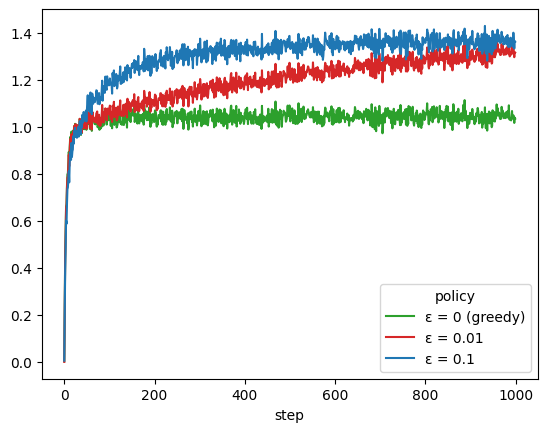

In [4]:
policy_names = {
    0: 'ε = 0.1',
    1: 'ε = 0.01',
    2: 'ε = 0 (greedy)'
}

colors = {
    'ε = 0.1': 'tab:blue',
    'ε = 0.01': 'tab:red',
    'ε = 0 (greedy)': 'tab:green'
}

(
    trace_df
    .assign(policy=trace_df.policy_idx.map(policy_names))
    .groupby(['step', 'policy'])
    ['reward'].mean()
    .unstack()
    .plot(color=colors)
)

## Controlling the evaluation loop

The `bandit.evaluate` function is useful for benchmarking. But in practice, you'll want to have control over your bandit policy. Indeed you'll want the freedom to pull arms (with the `pull` method) and update the policy (with the `update` method) at your discretion.

As an example, the following is a possible reimplementation of the `bandit.evaluate` function. Here we'll be measuring the rate at which each policy selects the optimal arm.

Note how the `pull` and `update` methods are used.

In [5]:
import copy

policies=[
    bandit.EpsilonGreedy(epsilon=0.1),
    bandit.EpsilonGreedy(epsilon=0.01),
    bandit.EpsilonGreedy(epsilon=0),
]

env = gym.make(
    'river_bandits/KArmedTestbed-v0',
    max_episode_steps=1000
)
n_episodes = 2000

trace = []

with tqdm(total=len(policies) * n_episodes * env._max_episode_steps, position=0) as progress:
    for policy in policies:
        for episode in range(n_episodes):
            episode_policy = policy.clone()
            episode_env = copy.deepcopy(env)
            episode_env.reset()
            step = 0
            while True:
                action = next(episode_policy.pull(range(episode_env.action_space.n)))
                observation, reward, terminated, truncated, info = episode_env.step(action)
                best_action = observation
                episode_policy.update(action, reward)

                trace.append({
                    "episode": episode,
                    "step": step,
                    "policy": f"ε = {policy.epsilon}",
                    "is_action_optimal": action == best_action
                })
                step += 1
                progress.update()
                
                if terminated or truncated:
                    break

trace_df = pd.DataFrame(trace)

  0%|          | 0/6000000 [00:00<?, ?it/s]/opt/hostedtoolcache/Python/3.9.16/x64/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 6000000/6000000 [01:30<00:00, 66658.41it/s]


<Axes: xlabel='step'>

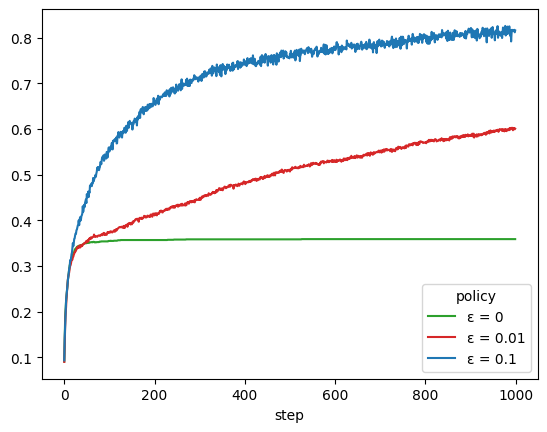

In [6]:
colors = {
    'ε = 0.1': 'tab:blue',
    'ε = 0.01': 'tab:red',
    'ε = 0': 'tab:green'
}

(
    trace_df
    .groupby(['step', 'policy'])
    ['is_action_optimal'].mean()
    .unstack()
    .plot(color=colors)
)

## Handling drift

The environment used above is a toy situation used for introducing bandits. It is stationary, meaning that the expected reward of each arm does not change over time.

In practice, arms are dynamic, and their performance can vary over time. A simple example of this is the [Candy Cane Contest](https://www.kaggle.com/c/santa-2020) that was hosted on Kaggle in 2020. The expected reward of each arm diminishes each time it is pulled.

The way bandit policies in River deal with drift depends on the method. For the `bandit.EpsilonGreedy` policy, it makes sense to use a rolling average as the reward object. What this means is that the empirical reward the policy calculates for each arm is a rolling average, rather than a global one.

In [7]:
from river import proba, utils

policies=[
    bandit.EpsilonGreedy(
        epsilon=0.1,
        seed=42
    ),
    bandit.EpsilonGreedy(
        epsilon=0.3,
        reward_obj=utils.Rolling(stats.Mean(), window_size=50),
        seed=42
    ),
    bandit.ThompsonSampling(
        dist=proba.Beta(),
        seed=42
    )
]

env = gym.make('river_bandits/CandyCaneContest-v0')

trace = bandit.evaluate(
    policies=policies,
    env=env,
    pull_func=pull_func,
    n_episodes=(n_episodes := 30),
    seed=42
)

trace_df = pd.DataFrame(tqdm(
    trace, position=0, total=(
        n_episodes *
        len(policies) *
        env._max_episode_steps
    )
))

  0%|          | 0/180000 [00:00<?, ?it/s]/opt/hostedtoolcache/Python/3.9.16/x64/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 180000/180000 [00:29<00:00, 6062.61it/s]


We can compare the performance of each policy by checking the average reward at the end of each episode.

In [8]:
(
    trace_df
    .groupby(['policy_idx', 'episode'])
    .last()
    .groupby('policy_idx')
    .reward_stat.mean()
)

policy_idx
0    736.1
1    817.0
2    854.0
Name: reward_stat, dtype: float64

We see that using a rolling average gives a boost to the epsilon greedy strategy. However, we see that the `bandit.ThompsonSampling` policy performs even better, even though no particular care was given to drift. A natural next step would thus be to see how it could be improved to handle drift. For instance, its `dist` parameter could be wrapped with a `utils.Rolling`:

In [9]:
policy = bandit.ThompsonSampling(
    dist=utils.Rolling(proba.Beta(), window_size=50),
    seed=42
)

Bandits can be used for several tasks. They can be used for content personalization, as well as online model selection (see `model_selection.BanditRegressor`). The policies in River are therefore designed to be flexible, so that they can be used in conjunction with other River modules. For instance, the `reward_obj` in `bandit.EpsilonGreedy` can be a metric, a probability distribution, or a statistic. This works because objects in River adher to a coherent get/update interface.